Este script genera graficos de frecuencia instantanea de la DOE vs. tiempo durante el estimulo. Superpone cada estimulacion y las separa en sub-plots por hora consecutiva de estimulacion. Tiene la opcion de separar entre el trial de la mañana y la tarde.

Toma los archivos .pkl obtenidos de 'EOD_analysis.py' y los .csv registrados con bonsai con los timestamps de los on y off del objeto. Puede ser adaptado para graficar raster-plot, graficar todas las horas de estimulacion en uno y cambiar los rangos de tiempo de interes para plotear. 

In [1]:
#importamos los paquetes
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import pickle
from datetime import datetime, timedelta
from scipy.stats import zscore

#cambiamos la carpeta de trabajo y cargamos los archivos
data_folder = '/Volumes/Expansion/datos_GPetersii/datos_GPetersii/Fish1/Object/raw' #cambiar a ruta con archivos .bin
os.chdir(data_folder)

files_EOD = sorted(glob.glob('*.bin'))
#definimos parametros
sf = 50000


In [2]:
#cargamos el archivo de FB-DOE
with open('fish1_FB-DOE.pkl', 'rb') as file:   #cambiar al nombre apropiado de archivo
        FB_doe = pickle.load(file)

A continuacion tenemos algunas celdas que pre-procesan nuestros datos y filtran los archivos para solo utilizar los que contienen registros durante la estimulacion.

In [4]:
# generamos la lista files_start que contiene las timestamps en formato datetime del comienzo de cada uno de los archivos
files_start = [datetime.strptime(key[:-1], '%Y-%m-%dT%H_%M_%S') for key in sorted(FB_doe['FB-DOE'].keys())]
print(files_start)

[datetime.datetime(2023, 6, 9, 16, 46, 17), datetime.datetime(2023, 6, 9, 17, 6, 17), datetime.datetime(2023, 6, 9, 17, 26, 17), datetime.datetime(2023, 6, 9, 17, 46, 17), datetime.datetime(2023, 6, 9, 18, 6, 18), datetime.datetime(2023, 6, 9, 18, 26, 18), datetime.datetime(2023, 6, 9, 18, 46, 18), datetime.datetime(2023, 6, 9, 19, 6, 18), datetime.datetime(2023, 6, 9, 19, 26, 18), datetime.datetime(2023, 6, 9, 19, 46, 18), datetime.datetime(2023, 6, 9, 20, 6, 18), datetime.datetime(2023, 6, 9, 20, 26, 19), datetime.datetime(2023, 6, 9, 20, 46, 19), datetime.datetime(2023, 6, 9, 21, 6, 19), datetime.datetime(2023, 6, 9, 21, 26, 19), datetime.datetime(2023, 6, 9, 21, 46, 19), datetime.datetime(2023, 6, 9, 22, 6, 19), datetime.datetime(2023, 6, 9, 22, 26, 19), datetime.datetime(2023, 6, 9, 22, 46, 20), datetime.datetime(2023, 6, 9, 23, 6, 20), datetime.datetime(2023, 6, 9, 23, 26, 20), datetime.datetime(2023, 6, 9, 23, 46, 20), datetime.datetime(2023, 6, 10, 0, 6, 20), datetime.datetime(

In [9]:
from datetime import datetime, timedelta

def generate_timestamps(start_date, hour1, delta):
    # Define the start and end times
    start_time = datetime(start_date.year, start_date.month, start_date.day, hour1, 0, 0)
    end_time = start_time + timedelta(hours=delta)  # 8 hours from 9 PM to 5 AM

    # Initialize an empty list to store timestamps
    timestamps = []

    # Generate timestamps at one-minute intervals
    current_time = start_time
    while current_time <= end_time:
        timestamps.append(current_time)
        current_time += timedelta(minutes=1)

    return timestamps

# Generamos las timestamps:
given_date = files_start[0] 
timestamps_obj = generate_timestamps(given_date, 17, 4)
timestamps_basal = generate_timestamps(given_date, 21, 8)


In [10]:
import random
from datetime import datetime, timedelta


# Function to randomly sample 60 timestamps
def sample_random_timestamps(timestamps, seed):
    # Ensure that we have at least 60 timestamps available
    if len(timestamps) < 60:
        raise ValueError("Not enough timestamps to sample from.")

    random.seed(seed)
    # Sample 60 timestamps randomly
    sampled_timestamps = random.sample(timestamps, 60)
    return sampled_timestamps

# Sample 60 random timestamps
random_timestamps_b = sorted(sample_random_timestamps(timestamps_basal, seed=187672))
random_timestamps_o = sorted(sample_random_timestamps(timestamps_obj, seed=13))
del timestamps_basal, timestamps_obj

In [11]:
nueve = datetime(given_date.year, given_date.month, given_date.day, 21, 0, 0)
cinco = nueve + timedelta(hours=8) 

keys = [x for i, x in enumerate(sorted(FB_doe['FB-DOE'].keys())) if files_start[i] > nueve and files_start[i] < cinco]
k_idx = [i for i, x in enumerate(sorted(FB_doe['FB-DOE'].keys())) if files_start[i] > nueve and files_start[i] < cinco]
FB_DOE = {key: FB_doe['FB-DOE'][key] for key in keys}
Peak_time = {key: FB_doe['Peak-time'][key] for key in keys}# guardamos los peak-times en otra variable
n_files = len(keys)
del cinco, nueve

In [12]:
files_start = [files_start[x] for x in k_idx] #nos quedamos solo con los timestamps de los archivos de interes
files_start


[datetime.datetime(2023, 6, 9, 21, 6, 19),
 datetime.datetime(2023, 6, 9, 21, 26, 19),
 datetime.datetime(2023, 6, 9, 21, 46, 19),
 datetime.datetime(2023, 6, 9, 22, 6, 19),
 datetime.datetime(2023, 6, 9, 22, 26, 19),
 datetime.datetime(2023, 6, 9, 22, 46, 20),
 datetime.datetime(2023, 6, 9, 23, 6, 20),
 datetime.datetime(2023, 6, 9, 23, 26, 20),
 datetime.datetime(2023, 6, 9, 23, 46, 20),
 datetime.datetime(2023, 6, 10, 0, 6, 20),
 datetime.datetime(2023, 6, 10, 0, 26, 20),
 datetime.datetime(2023, 6, 10, 0, 46, 20),
 datetime.datetime(2023, 6, 10, 1, 6, 21),
 datetime.datetime(2023, 6, 10, 1, 26, 21),
 datetime.datetime(2023, 6, 10, 1, 46, 21),
 datetime.datetime(2023, 6, 10, 2, 6, 21),
 datetime.datetime(2023, 6, 10, 2, 26, 21),
 datetime.datetime(2023, 6, 10, 2, 46, 21),
 datetime.datetime(2023, 6, 10, 3, 6, 22),
 datetime.datetime(2023, 6, 10, 3, 26, 22),
 datetime.datetime(2023, 6, 10, 3, 46, 22),
 datetime.datetime(2023, 6, 10, 4, 6, 22),
 datetime.datetime(2023, 6, 10, 4, 26, 2

In [13]:
#organizamos cada on segun su archivo de registro
files = pd.DataFrame(np.zeros(shape=(20, n_files)), columns=sorted(keys))  # Usamos Int64Dtype para que pueda haber nans en columnas de int

for i, column in enumerate(files.columns[:-1], start=0):
    start = files_start[i]
    end = files_start[i+1]
    s = 0
    for j in range(1,len(random_timestamps_b)):
        condition = (start - random_timestamps_b[j]).total_seconds() < 0 and (end - random_timestamps_b[j]).total_seconds() > 0
        if condition:
            files.loc[s, column] = j
            s += 1

files = files.dropna(how='all')
files.replace(0, np.nan, inplace=True) # como inicializamos con una matriz de 0s, si hay algun archivo con menos de 5 ons vamos a tener 0s donde no deben haber, entonces los convertimos a nan
#files.iloc[0, 0] = 0 # el primer objeto tiene que ser un 0
files = files.dropna(how='all')
files = files.dropna(how='all', axis=1)

files

,2023-06-09T21_06_19.,2023-06-09T21_26_19.,2023-06-09T21_46_19.,2023-06-09T22_06_19.,2023-06-09T22_26_19.,2023-06-09T22_46_20.,2023-06-09T23_06_20.,2023-06-09T23_26_20.,2023-06-09T23_46_20.,2023-06-10T00_06_20.,...,2023-06-10T01_06_21.,2023-06-10T01_26_21.,2023-06-10T01_46_21.,2023-06-10T02_06_21.,2023-06-10T02_26_21.,2023-06-10T02_46_21.,2023-06-10T03_06_22.,2023-06-10T03_46_22.,2023-06-10T04_06_22.,2023-06-10T04_26_22.
0,1.0,3.0,4.0,5.0,8.0,13.0,14.0,16.0,17.0,18.0,...,28.0,31.0,33.0,34.0,35.0,36.0,39.0,48.0,52.0,54.0
1,2.0,NaN,NaN,6.0,9.0,NaN,15.0,NaN,NaN,NaN,...,29.0,32.0,NaN,NaN,NaN,37.0,40.0,49.0,53.0,55.0
2,NaN,NaN,NaN,7.0,10.0,NaN,NaN,NaN,NaN,NaN,...,30.0,NaN,NaN,NaN,NaN,38.0,41.0,50.0,NaN,56.0
3,NaN,NaN,NaN,NaN,11.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,42.0,51.0,NaN,NaN
4,NaN,NaN,NaN,NaN,12.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,43.0,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,44.0,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,45.0,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,46.0,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,47.0,NaN,NaN,NaN


In [14]:
#inicializamos las listas
EOD_peaks_on = []
time_EOD_all  = []
time_obj_all = []
EOD_f_on = []

In [15]:
for k, key in enumerate(files.keys()): #loopeamos entre los archivos de interes
    midnight = files_start[k].replace(hour=0, minute=0, second=0, microsecond=0) #definimos la media noche para el dia donde se registro ese archivo
    start = abs(midnight - files_start[k]).total_seconds() # calculamos el tiempo de inicio del archivo en segundos totales respecto de las 00 para poder compararla
    EOD = np.fromfile(files_EOD[k],dtype=np.int16)
    time_EOD = np.linspace(start=start, stop=start+len(EOD)/sf, num=len(EOD))
    del EOD

    EOD_peaks = np.array(Peak_time[key])
    EOD_freq = np.array(FB_DOE[key])
    time_obj = np.zeros((files.shape[0]+1)) #inicializamos nuestra matriz de tiempo de prendida de obj (cada archivo puede tener maximo 5 ons, por eso las dimensiones)

    l=0
    for i in files.iloc[:,k]:
        if not np.isnan(i):
                s = abs(midnight - random_timestamps_b[int(i)]).total_seconds() #calculamos el inicio del on
                time_obj[l] = s
                time_obj_all.append(s) #guardamos el tiempo de este on en nuestra lista de tiempos de objeto
                time_EOD_all.append(time_EOD) #guardamos una copia de time_EOD para cada on 
                l+=1
    
    time_peaks = time_EOD[EOD_peaks]
    EOD_zscore = zscore(EOD_freq)
    del EOD_freq, time_EOD
    for j in range(time_obj.shape[0]):
        if not time_obj[j]==0:
            range_on = [time_obj[j]-.5, time_obj[j]+10] #definimos el rango de interes: 1/2 segundo antes que sea el on y 2 segundos despues
            #con = [range_on[0] <= t and t <= range_on[1] for t in videoTime]
            condition = [range_on[0] <= time and time <= range_on[1] for time in time_peaks]

            EOD_peaks_on.append(EOD_peaks[condition])
            EOD_f_on.append(EOD_zscore[condition])
    del EOD_peaks, EOD_zscore, FB_DOE[key], Peak_time[key]

    print('termino archivo ' + str(k))

termino archivo 0
termino archivo 1


KeyboardInterrupt: 

Las siguientes celdas contienen el codigo para generar las graficas. La primera genera la paleta de colores, la segunda genera el plot para todos los trials juntos y la tercera para los trials 1 y 2 separados

In [18]:
import matplotlib.cm as cm
colormap = cm.get_cmap('cool')
colors = [colormap(i+100) for i in range(len(time_obj_all))]

/var/folders/dk/0fvz37fn27l9149spycxsyf80000gp/T/ipykernel_67911/1860149869.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('cool')


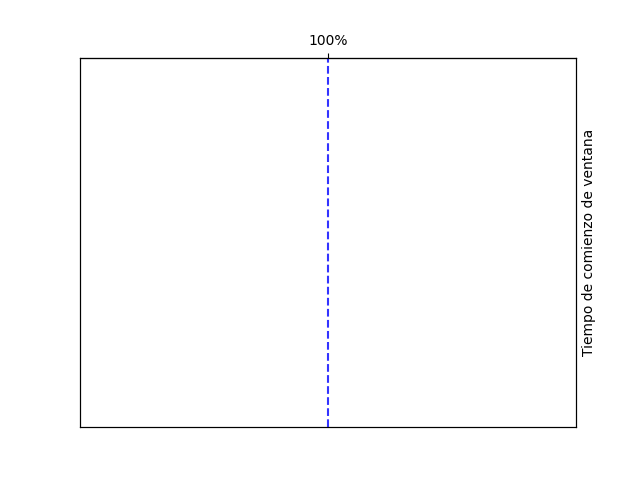

In [19]:
%matplotlib widget 
#plot all trials
n_per_on = []
t_novelty = []
trials = []
n_peaks = []
fig, ax = plt.subplots()
ax2 = ax.twinx()
k=0

EOD_zscore = EOD_f_on
    
if len(EOD_zscore)>0 :
    for z_score, peak, t, o, c in zip(EOD_zscore, EOD_peaks_on, time_EOD_all,  time_obj_all, colors):
        peak = peak[:len(z_score)]
        #plt.scatter(t[peak]-o, np.ones(len(peak))*k, color=c, s=1)
            
        i_novel = peak[z_score > 1.8]
        novel = [i for i in z_score if i >1.8]
        if len(peak) > 0:
            n_per_on.append(len(i_novel)/ len(peak))
        else:
            n_per_on.append(0)
        n_peaks.append(len(peak))
        t_novelty.append(o)
        trials.append(k)
        plt.scatter(t[i_novel]-o, np.ones(len(i_novel))*k, color=c, s=3)
        k += .01

        ax.set_ylabel('Ventanas de 10 s basal')
        ax.set_xlabel('Tiempo (s)')


bar_width = .01
for i, y in zip(trials,n_per_on):
    bar_position = 10 -y +2
    ax2.barh(i + bar_width*i, y, height=bar_width, color='k', alpha=.5, left=bar_position)  # Bar for each line

hours = [int(trial // 3600) for trial in t_novelty]
minutes = [int(trial % 3600) // 60 for trial in t_novelty]
dates = [datetime.now().replace(hour=hour, minute=minute, second=0, microsecond=0) for hour, minute in zip(hours, minutes)]

ax.set_yticks([])

ax.set_xticks([0,2,4,6,8,10])
ax.set_xticklabels([0, 2,4,6,8,10])
ax2.axvline(x=11, color='b', linestyle='--',alpha=.8, label='Vertical Line')

x_hist = ax.secondary_xaxis('top')
x_hist.set_xticks([11])
x_hist.set_xticklabels(['100%'])
ax2.set_yticks(np.linspace(0,k,len(trials)))
ax2.set_yticklabels([date.strftime("%H:%M") for date in dates], fontsize=8)

ax2.set_ylabel('Tiempo de comienzo de ventana')
plt.show()


In [60]:
p = sum([x*y for x,y in zip(n_per_on, n_peaks)])/630
p

3.265079365079365